In [1]:
from bs4 import BeautifulSoup
import requests

url = "https://www.tenderned.nl/over-tenderned/datasets-aanbestedingen"

soup  = BeautifulSoup(requests.get(url).content, "html.parser")

links = [link for link in [a.attrs["href"] for a in soup.find_all("a")] if "Dataset" in link]
links

['https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q1_Q2.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q3_Q4_0.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2013.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2012.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2010_2011.xlsx']

In [2]:
import re
import pandas as pd

# i'll need this later
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

names = [re.match(r'.*TenderNed_(.*)\.xlsx', link).groups()[0] for link in links]
frames = [pd.read_excel(link) for link in links]

names

['2016_Q1_Q2', '2016_Q3_Q4_0', '2015', '2014', '2013', '2012', '2010_2011']

In [3]:
import seaborn.apionly as sns
from functools import reduce

%pylab inline

Populating the interactive namespace from numpy and matplotlib


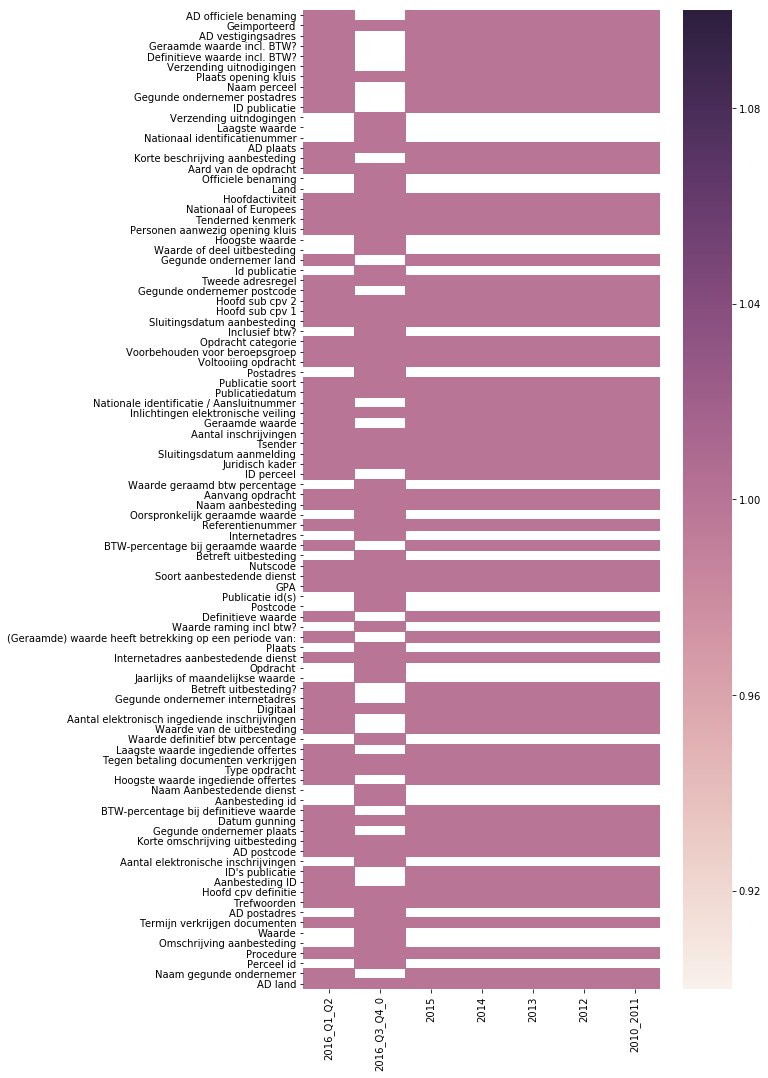

In [4]:
all_columns = set(reduce(lambda x, y: x + y, [list(df.columns) for df in frames]))

missing = pd.DataFrame(index=all_columns)

for name, frame in zip(names, frames):

    missing.loc[frame.columns, name] = 1

plt.figure(figsize = (8, 18))
sns.heatmap(missing)

In [10]:
import string

def sanitize(name):

    t = "".join([c if c in string.ascii_lowercase + string.digits else "_" for c in name.lower()])
    return re.sub(r"_+", "_", t).lstrip("_").rstrip("_")

sanitize(clean_frames[0].columns[-3])

'korte_omschrijving_uitbesteding'

In [7]:
def transform(df, name, link):

    return df.rename(columns=sanitize).assign(
        name = name,
        link = link
    )

clean_frames = [transform(df, name, link) for df, name, link in zip(frames, names, links) if not "2016_Q3" in name]

tenders = pd.concat(clean_frames)
tenders.head()

,id_publicatie,tenderned_kenmerk,publicatiedatum,ad_officiele_benaming,nationale_identificatie_aansluitnummer,naam_aanbesteding,geimporteerd,tsender,aanbesteding_id,sluitingsdatum_aanmelding,sluitingsdatum_aanbesteding,aanvang_opdracht,voltooiing_opdracht,termijn_verkrijgen_documenten,verzending_uitnodigingen,tegen_betaling_documenten_verkrijgen,personen_aanwezig_opening_kluis,plaats_opening_kluis,nationaal_of_europees,korte_beschrijving_aanbesteding,publicatie_soort,juridisch_kader,type_opdracht,procedure,trefwoorden,referentienummer,digitaal,voorbehouden_voor_beroepsgroep,hoofd_cpv_definitie,hoofd_sub_cpv_1,hoofd_sub_cpv_2,opdracht_categorie,nutscode,aard_van_de_opdracht,gpa,inlichtingen_elektronische_veiling,ad_vestigingsadres,tweede_adresregel,ad_plaats,ad_postcode,ad_land,internetadres_aanbestedende_dienst,soort_aanbestedende_dienst,hoofdactiviteit,id_s_publicatie,id_perceel,naam_perceel,datum_gunning,aantal_inschrijvingen,aantal_elektronisch_ingediende_inschrijvingen,naam_gegunde_ondernemer,gegunde_ondernemer_postadres,gegunde_ondernemer_plaats,gegunde_ondernemer_postcode,gegunde_ondernemer_land,gegunde_ondernemer_internetadres,geraamde_waarde,btw_percentage_bij_geraamde_waarde,geraamde_waarde_incl_btw,laagste_waarde_ingediende_offertes,hoogste_waarde_ingediende_offertes,geraamde_waarde_heeft_betrekking_op_een_periode_van,definitieve_waarde,btw_percentage_bij_definitieve_waarde,definitieve_waarde_incl_btw,betreft_uitbesteding,waarde_van_de_uitbesteding,korte_omschrijving_uitbesteding,link,name
0,72152,72525,04-01-2016,Koning Willem I College,21372421,Schoolmeubilair,Nee,NaN,72525,08-09-2015,02-11-2015,01-01-2016,31-12-2017,07-09-2015,21-09-2015,Nee,Nee,NaN,Europees,Levering van schoolmeubilair,Aankondiging van een gegunde opdracht,Aanbestedingswet 2012,Leveringen,Niet-openbaar,,EEG/49/INK,Ja,NaN,"39160000-1 Schoolmeubilair, 39160000-1 Schoolm...",NaN,NaN,"Aankoop, Aankoop","NL, NL413",Raamovereenkomst,Ja,Nee,Vlijmenseweg 2,Inkoop Facilitair Bedrijf,'S-HERTOGENBOSCH,5223GW,Nederland,http://www.kw1c.nl,Publiekrechtelijke instelling,Onderwijs,72152,NaN,NaN,18-12-2015,4.0,4.0,Ahrend Nederland B.V.,Postbus 1,Sint-Oedenrode,5490AA,NL,http://www.ahrend.com,NaN,NaN,NaN,EUR 92572.3,EUR 120580,1 Jaren,NaN,NaN,NaN,Nee,NaN,NaN,https://www.tenderned.nl/sites/default/files//...,2016_Q1_Q2
1,72154,75754,04-01-2016,"Ministerie van Economische Zaken, Rijksdienst ...",12024663,Fashion forcasts,Nee,NaN,75754,NaN,25-09-2015,NaN,NaN,NaN,NaN,Nee,Nee,NaN,Europees,The Centre for the Promotion of Imports from d...,Aankondiging van een gegunde opdracht,Aanbestedingswet 2012,Diensten,Openbaar,marktonderzoek mode forecast apparel fashion,NaN,Ja,NaN,79300000-7 Markt- en economieonderzoek; enquêt...,NaN,NaN,Markt- en opinieonderzoek,NL,Overheidsopdracht,Ja,Nee,Prinses Beatrixlaan 2,NaN,Den Haag,2595 AL,Nederland,http://www.rvo.nl,Ministerie of andere nationale of federale ins...,Economische en financiële zaken,72154,NaN,NaN,02-12-2015,3.0,3.0,Louk Grauwen Design,Weteringschans 261 D,AMSTERDAM,1017XJ,NL,NaN,EUR 200000,NaN,NaN,NaN,NaN,4 Jaren,EUR 200000,NaN,NaN,Nee,NaN,NaN,https://www.tenderned.nl/sites/default/files//...,2016_Q1_Q2
2,72155,85218,04-01-2016,Cyclus N.V.,17681849,Rioolreiniging en inspectie 2016-2017,Nee,NaN,85218,NaN,21-01-2016,01-03-2016,31-12-2016,13-01-2016,NaN,Nee,Nee,NaN,Europees,"Reiniging en inspecteren van riolering, met bi...","Kennisgeving van aanvullende informatie, infor...",ARW 2012 - Aanbestedingsreglement Werken 2012,Diensten,Openbaar,Riolering Reiniging Inspectie,NaN,Ja,NaN,90470000-2 Diensten voor rioolreiniging,NaN,NaN,Overige diensten,NL,Raamovereenkomst,Ja,Nee,Goudkade 23,NaN,GOUDA,2802AA,Nederland,http://www.cyclusnv.nl,Publiekrechtelijke instelling,Milieu,"75866, 72905, 72155",NaN,NaN,29-02-2016,7.0,7.0,GMB Rioleringstechnieken B.V,Postbus 373,KAMPEN,8260AJ,NL,http://www.gmb.eu,EUR 180000,NaN,NaN,EUR 135000,EUR 820000,NaN,NaN,NaN,NaN,Nee,NaN,NaN,https://www.tenderned.nl/sites/default/files//...,2016_Q1_Q2
3,72156,7

In [8]:
def count_dupes(col):
    return pd.Series({
        "duplications": col.duplicated().sum(),
        "unique_values": len(col.unique()),
        "na": col.isnull().sum(),
        "na + duplications": (col.duplicated() | col.isnull()).sum()
    })

tenders.apply(count_dupes, axis = 0).T.sort_values("duplications")

,duplications,na,na + duplications,unique_values
id_publicatie,14994,0,14994,43295
tenderned_kenmerk,33137,0,33137,25152
aanbesteding_id,33137,0,33137,25152
korte_beschrijving_aanbesteding,35803,51,35804,22486
naam_aanbesteding,36222,0,36222,22067
referentienummer,41271,13614,41272,17018
trefwoorden,48636,10465,48637,9653
naam_gegunde_ondernemer,50474,29203,50475,7815
id_s_publicatie,50999,29203,51000,7290
gegunde_ondernemer_postcode,51968,29432,51969,6321


## Omschrijvingen

* Klein probleempje, postadres heet vestigingsadres in de data

In [12]:
columns = pd.read_excel(
    "https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q1_Q2.xlsx", 
    sheetname=1, skiprows=10)

columns.sample(5)

,Kolomtitel,Toelichting
2,Publicatiedatum,De datum waarop de aankondiging is gepubliceerd
38,AD plaats,Vestigingsplaats van de aanbestedende dienst
14,Verzending uitnodigingen,De geplande datum waarop onderhandse uitnodigi...
54,Gegunde ondernemer land,Vestigingsland van de ondernemer
49,Aantal elektronisch ingediende inschrijvingen,Het aantal elektronisch (digitaal) ontvangen i...


In [13]:
columns["short_name"] = columns.Kolomtitel.map(sanitize)
columns.sample(5)

,Kolomtitel,Toelichting,short_name
6,Geimporteerd,Is de aankondiging geïmporteerd uit een ander ...,geimporteerd
47,Datum gunning,De datum van de gunning aan de ondernmer(s),datum_gunning
2,Publicatiedatum,De datum waarop de aankondiging is gepubliceerd,publicatiedatum
63,BTW-percentage bij definitieve waarde,De hoogte van het BTW-percentage van de defini...,btw_percentage_bij_definitieve_waarde
18,Nationaal of Europees,Is het een Europese of nationale openbare proc...,nationaal_of_europees


In [17]:


x = set(tenders.columns)
y = set(columns.short_name)

x.difference(y), y.difference(x)

({'ad_vestigingsadres', 'link', 'name'}, {'ad_postadres'})